# Imports

In [ ]:
import cv2
import importlib.resources as resources
import logging
import matplotlib.pyplot as plt
import numpy as np

from anypick_dk.grounded_sam_wrapper import GroundedSamWrapper
from anypick_dk.planner import Planner
from anypick_dk.sim_environment import SimEnvironment
from anypick_dk.utils import get_pc_from_depth, transform_pointcloud
from pydrake.all import Concatenate, Rgba

logging.basicConfig(level=logging.INFO)

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
scenario_file = str(resources.files("anypick_dk") / "scenarios" / "shelf_with_objects.yaml")
sim_env = SimEnvironment(scenario_file)
planner = Planner(sim_env)
sim_env.publish_diagram()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# View Camera Images

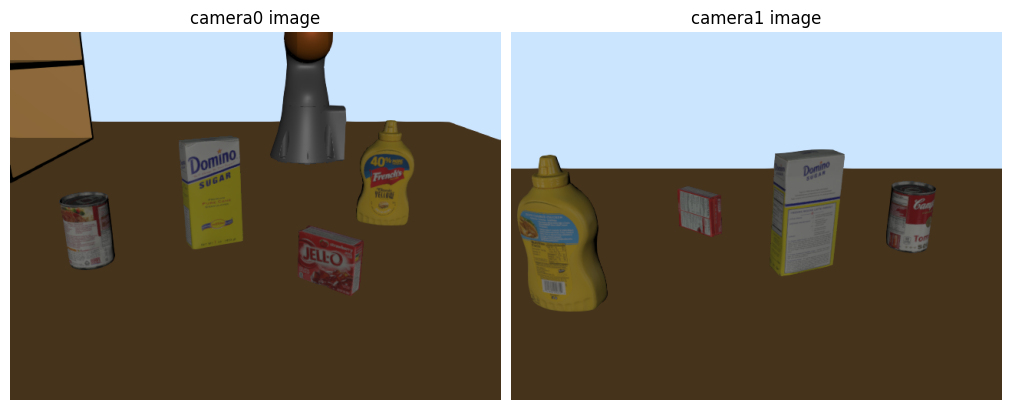

In [3]:
cameras = [0, 1]
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = sim_env.get_camera_bgr(cam)
    im = ax.imshow(img[:,:,::-1])
    ax.set_title(f"camera{cam} image")
    ax.axis("off")

plt.show()

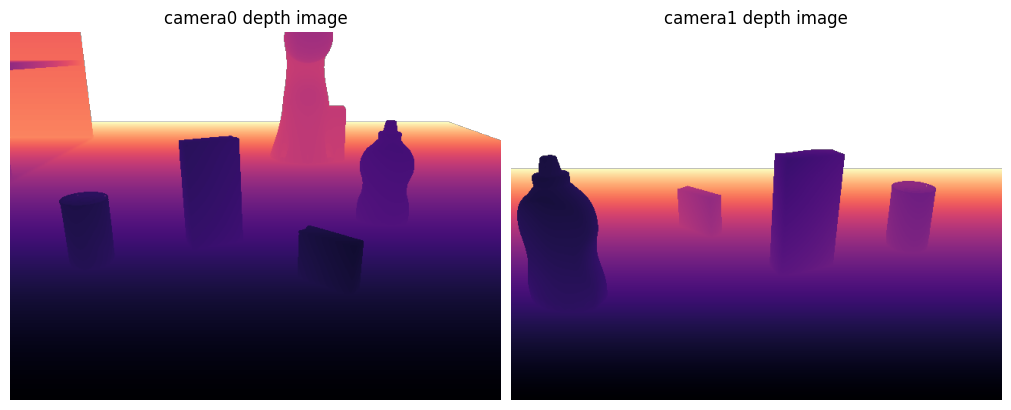

In [4]:
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    depth_img = sim_env.get_camera_depth(cam)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"camera{cam} depth image")
    ax.axis("off")

plt.show()

# Run GroundedSAM

Working prompts are:
- "the mustard bottle"
- "the red box" or "the red jello box"
- "the yellow and white box"
- "the can"

In [5]:
gdsam = GroundedSamWrapper()

final text_encoder_type: bert-base-uncased


In [6]:
prompt = ["the red box"]

In [7]:
img0 = sim_env.get_camera_bgr(0)
bboxes0, masks0 = gdsam.detect_and_segment(img0, prompt)
gdsam.annotate_and_save(img0, output_path=f"camera0_detection_test.png")

INFO:anypick_dk.grounded_sam_wrapper:Saved annotated image to camera0_detection_test.png


In [8]:
img1 = sim_env.get_camera_bgr(1)
bboxes1, masks1 = gdsam.detect_and_segment(img1, prompt)
gdsam.annotate_and_save(img1, output_path=f"camera1_detection_test.png")

INFO:anypick_dk.grounded_sam_wrapper:Saved annotated image to camera1_detection_test.png


In [10]:
kernel = np.ones((7, 7), np.uint8)
masks0_eroded = cv2.erode(masks0.astype(np.uint8) * 255, kernel, iterations=1).astype(bool)
masks1_eroded = cv2.erode(masks1.astype(np.uint8) * 255, kernel, iterations=1).astype(bool)

In [11]:
intrinsics0 = sim_env.get_camera_intrinsics(0)
depth_img0 = sim_env.get_camera_depth(0)
masked_depth0 = depth_img0.copy()
masked_depth0[~masks0_eroded] = 0.0
cam0_pc_local = get_pc_from_depth(masked_depth0, intrinsics0)
X_WC0 = sim_env.get_camera_pose(0)
cam0_pc_world = transform_pointcloud(cam0_pc_local, X_WC0)

In [12]:
intrinsics1 = sim_env.get_camera_intrinsics(1)
depth_img1 = sim_env.get_camera_depth(1)
masked_depth1 = depth_img.copy()
masked_depth1[~masks1_eroded] = 0.0
cam1_pc_local = get_pc_from_depth(masked_depth1, intrinsics1)
X_WC1 = sim_env.get_camera_pose(1)
cam1_pc_world = transform_pointcloud(cam1_pc_local, X_WC1)

In [13]:
obj_pc = Concatenate([cam0_pc_world, cam1_pc_world])
obj_pc = obj_pc.VoxelizedDownSample(voxel_size=0.005)
sim_env.meshcat.SetObject(
    "letter_point_cloud", obj_pc, point_size=0.01, rgba=Rgba(1, 0, 0)
)